In [97]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import umap

In [98]:
# This functions aligns a target array with the passed annotation dataframe using specimen ids
def align(array, specimen_ids, anno):
    aligned_array = np.stack([np.full_like(array[0], np.nan)] * len(anno))
    id_df = pd.DataFrame(data = {"specimen_id": specimen_ids, "alignment_index": range(len(specimen_ids))})
    id_df["specimen_id"] = id_df["specimen_id"].str.strip()
    aligned_indices = pd.merge(anno, id_df, on = "specimen_id", how = "inner")
    aligned_array[aligned_indices["row_index"].to_numpy()] =  array[aligned_indices["alignment_index"].to_numpy()]
    return aligned_array

# This function selects data from the target array based on which rows are present in the passed annotation
def select(array, anno):
    selected = array[anno["row_index"]]
    return selected

# This function samples from the passed dataframes to ensure that there is an equal number of samples
# from each experiment across excitatory cells and inhibitory cells
def normalize_sample_count(exp1, exp2, anno):
    unnormalized = anno.query("platform == @exp1 or platform == @exp2")
    exp1_exc = unnormalized.query("platform == @exp1 and `class` == 'exc'")
    exp1_inh = unnormalized.query("platform == @exp1 and `class` == 'inh'")
    exp2_exc = unnormalized.query("platform == @exp2 and `class` == 'exc'")
    exp2_inh = unnormalized.query("platform == @exp2 and `class` == 'inh'")
    if len(exp1_exc) > len(exp2_exc):
       exp1_exc = exp1_exc.sample(len(exp2_exc), replace = False)
    else:
        exp2_exc = exp2_exc.sample(len(exp1_exc), replace = False)
    if len(exp1_inh) > len(exp2_inh):
       exp1_inh = exp1_inh.sample(len(exp2_inh), replace = False)
    else:
        exp2_inh = exp2_inh.sample(len(exp1_inh), replace = False)
    anno_samp = pd.concat([exp1_exc, exp1_inh, exp2_exc, exp2_inh])
    return (unnormalized, anno_samp)

### Load data

We begin by loading the arbor density, latent space, and cell annotation data, and restrict ourselves to only those cells where morphological data is available. This data is taken from EM, ME, fMOST, and Patch-Seq experiments.

In [135]:
# Load cell annotation file
anno_full = pd.read_csv("../data/raw/exc_inh_ME_fMOST_EM_specimen_ids_shuffled_4Apr23.txt").rename(columns = {"Unnamed: 0": "row_index"})
anno_full["specimen_id"] = anno_full["specimen_id"].str.strip()
# Load arbor density data (generated by data_proc_M.py in Fahimeh's cplAE_MET repository)
arbor_dict = sio.loadmat("../data/raw/M_arbor_data_50k_4Apr23.mat")
arbors = align(arbor_dict["hist_ax_de_api_bas"], arbor_dict["specimen_id"], anno_full) # Always align with unfiltered annotation
# Filter out cells which do not have valid morphological data
anno = anno_full.query("M_cell")
anno

,row_index,specimen_id,platform,class,group,class_id,T_cell,E_cell,M_cell,subgroup,proofread
0,0,864691135274125285_199010,EM,exc,1,0.0,False,False,True,1,NaN
2,2,864691135212658304_427884,EM,exc,1,0.0,False,False,True,1,NaN
3,3,864691135354962383_392595,EM,exc,1,0.0,False,False,True,1,NaN
5,5,864691136656750077_610633,EM,exc,1,0.0,False,False,True,1,NaN
6,6,864691136898656366_396172,EM,exc,1,0.0,False,False,True,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
52252,52252,864691135750158472_388862,EM,exc,1,0.0,False,False,True,1,NaN
52254,52254,864691135373371848_297143,EM,exc,1,0.0,False,False,True,1,NaN
52255,52255,864691135714363796_557060,EM,exc,1,0.0,False,False,True,1,NaN
52256,52256,864691135587516402_491694,EM,exc,1,0.0,False,False,True,1,NaN


For each cell specimen, the arbor density data is an array of shape 120x4x4, except that the last dimension is split based on whether a cell is excitatory or inhibitory, with the index values 0 and 1 being reserved for inhibitory cells while values 2 and 3 are reserved for excitatory cells.

In [130]:
np.stack([arbors[0, 20:21], arbors[54, 20:21]]) # First array is an excitatory cell, second is an inhibitory cell

array([[[[0.        , 0.        , 0.84785634, 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ]]],


       [[[0.        , 0.63299759, 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ]]]])

Looking at the distribution of excitatory and inhibitory cells across the difference experiment types, we can see that there is a massive asymmetry for the EM data.

In [100]:
pd.pivot_table(anno, index = "platform", columns = "class", values = "row_index", aggfunc = "count")

class,exc,inh
platform,,
EM,43314.0,141.0
ME,244.0,203.0
fMOST,280.0,NaN
patchseq,831.0,788.0


We will account for this by randomly sampling from the full dataset such that there are an equal number (831) of excitatory cells between the two datasets and an equal number (141) of inhibitory cells between the two datasets.

In [151]:
(exp1, exp2) = ("EM", "patchseq") # Any two of "EM", "patchseq", "ME", and "fMOST" can be used here for subsequent comparisons
(anno_unnorm, anno_samp) = normalize_sample_count(exp1, exp2, anno)

### Raw data analysis

To gauge the degree of separation/clustering that already exists in the raw morphological data, we can train a simple linear discriminant classifier and assess its accuracy at distinguishing EM and Patch-Seq data. By enforcing equal priors across the two experiment types, we tie the accuracy of the classifier directly to how the data clusters.

In [102]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [136]:
flat_arbors = arbors.reshape((arbors.shape[0], -1)) # LDA requires flattened data
X = select(flat_arbors, anno_unnorm)
y = anno_unnorm["platform"] # Want to predict experiment type
linear = LDA(priors = [0.5, 0.5]).fit(X, y)
linear.score(select(flat_arbors, anno_samp), anno_samp["platform"])

0.6445473251028807

The low accuracy here suggests that the EM and Patch-Seq data are not trivially separable. However, the excitatory and inhibitory arbor densities were encoded into distinct slices of the data array, and can therefore be learned independently by a classifier. Let's visualize any differences between cell types by projecting the arbor densities onto the 1D subspace generated by the LDA classifier, and then plotting the excitatory and inhibitory cells separately.

In [137]:
projected_arbors = linear.transform(select(flat_arbors, anno_samp))

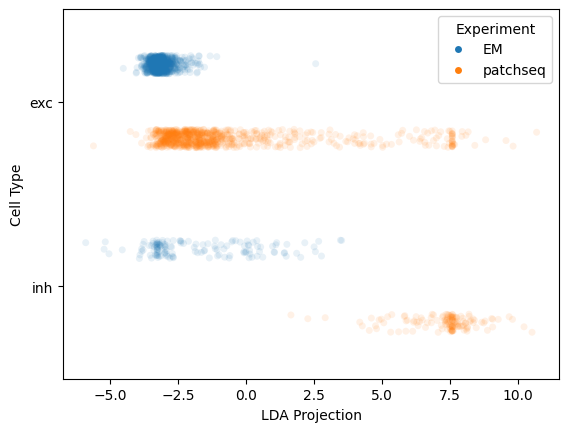

In [140]:
%matplotlib inline
plot = sns.stripplot(
    data = {"LDA Projection": projected_arbors.squeeze(), "Experiment": anno_samp["platform"], "Cell Type": anno_samp["class"]}, 
    x = "LDA Projection", y = "Cell Type", hue = "Experiment", alpha = 0.1, dodge = True)
for point in plot.legend_.legend_handles: # Remove transparency from legend symbols
    point._alpha = 1
plt.show()

We can see that the excitatory cells are more tightly clustered in the EM dataset versus Patch-Seq, but a large overlap still exists between the two experiments. Among inhibitory cells, by contrast, the two experiments form distinct clusters and are easy to separate.

One weakness of these LDA projections is that we cannot easily compare the excitatory and inhibitory cells within a single experiment type. To remedy this, we will merge the excitatory and inhibitory data slices and then create a 2D UMAP projection of the combined data.

In [106]:
arbors_comb = (arbors[..., :2] + arbors[..., 2:]).reshape((arbors.shape[0], -1)) # Merge two parts of last dimension
X_comb = select(arbors_comb, anno_unnorm)
umap_model = umap.UMAP().fit(X_comb)

In [107]:
proj = umap_model.transform(select(arbors_comb, anno_samp))

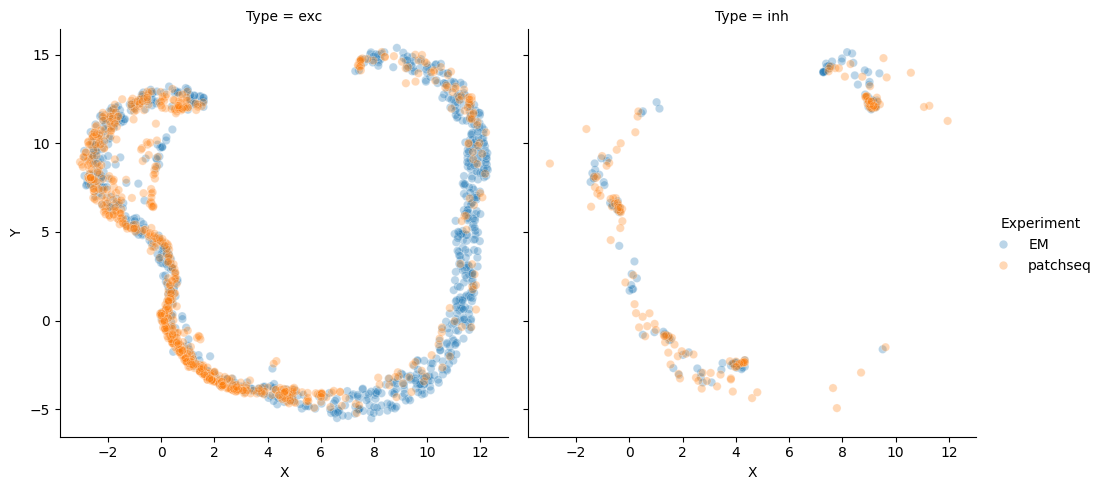

In [142]:
%matplotlib inline
plot = sns.relplot(
    data = {"X": proj[:, 0], "Y": proj[:, 1], "Experiment": anno_samp["platform"], "Type": anno_samp["class"]}, 
    x = "X", y = "Y", hue = "Experiment", col = "Type", alpha = 0.3)
plt.show()

Interestingly, the LDA and UMAP projections show different patterns. In the LDA excitatory clusters, we see that EM cells are more tightly packed than the Patch-Seq cells, while the opposite is true in the UMAP clusters. For the inhibitory cells, UMAP does not yield any real separation, while LDA is capable of significant separation. Both of these observations are likely attributable to the supervised nature LDA, which finds a projection direction in the 960-dimensional arbor space that explicitly seeks label separation (and is able to do so for excitatory and inhibitory cells independently), while UMAP tries to preserve the overall topology of the combined data even when much of it may not be useful for classification.

## Latent space analysis

Our ultimate goal is to understand the topology of the latent space in the morphology autoencoder. Given that we expect the encoder-decoder mapping to be relatively smooth, the topology of the raw data ought to be at least roughly reflected in the topology of a latent space that is optimized to reconstruct the original data. To evaluate this, we can plot the 3D latent representations of the EM and Patch-Seq experiments from a trained autoencoder.

In [109]:
# Load 3D latent space data
latent_dict = np.load("../data/remote/morpho/reference_3d/outputs.npz")
specimen_ids = latent_dict["specimen_ids"]
latent = align(latent_dict["latent_space"], latent_dict["specimen_ids"], anno_full)

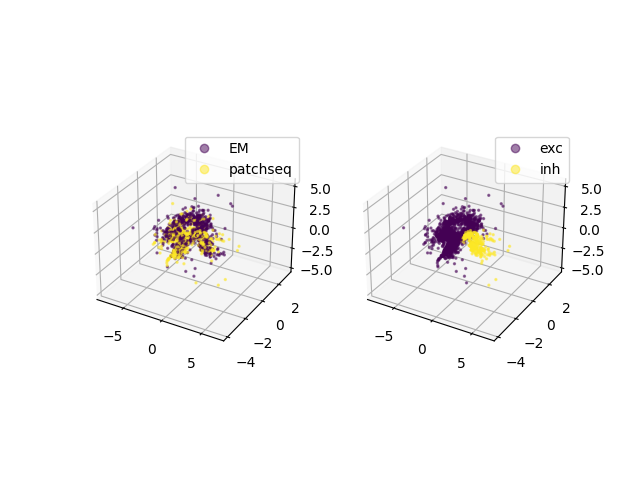

In [143]:
%matplotlib widget
latent_samp = select(latent, anno_samp)
fig = plt.figure()
ax_exp = fig.add_subplot(1, 2, 1, projection = "3d")
ax_type = fig.add_subplot(1, 2, 2, projection = "3d")
(factors_exp, labels_exp) = anno_samp["platform"].factorize() # For legend to match color with label
(factors_type, labels_type) = anno_samp["class"].factorize() # For legend to match color with label
sc_exp = ax_exp.scatter(latent_samp[:, 0], latent_samp[:, 1], latent_samp[:, 2], s = 2, alpha = 0.5, 
                c = factors_exp)
sc_type = ax_type.scatter(latent_samp[:, 0], latent_samp[:, 1], latent_samp[:, 2], s = 2, alpha = 0.5, 
                c = factors_type)
leg_exp = ax_exp.legend(sc_exp.legend_elements()[0], labels_exp.to_list())
leg_type = ax_type.legend(sc_type.legend_elements()[0], labels_type.to_list())
plt.show()

The plots shown above are consistent with our expectations. For the excitatory cells, we see the same 1D horseshoe topology as in the UMAP projections, except this time it slithers through 3D space. The distribution of EM and Patch-Seq data along the projection is also similar, with EM data spread across the entire surface while Patch-Seq is concentrated toward a single side. Looking at the inhibitory cells, we can see that they are fully separated from the excitatory cells, and do not possess any notable difference in distribution between EM and Patch-Seq.

For easier visualization, we can perform a 2D UMAP projection on the autoencoder's latent space (shown below). This makes it clear that the same horseshoe/U-shape topology exists in both the raw arbor density data and the latent space. However, since the excitatory and inhibitory data slices were separated for this autocoder experiment, the inhibitory cells are placed on their own distinct manifold.

In [111]:
proj_latent_sep = umap.UMAP().fit_transform(latent_samp)

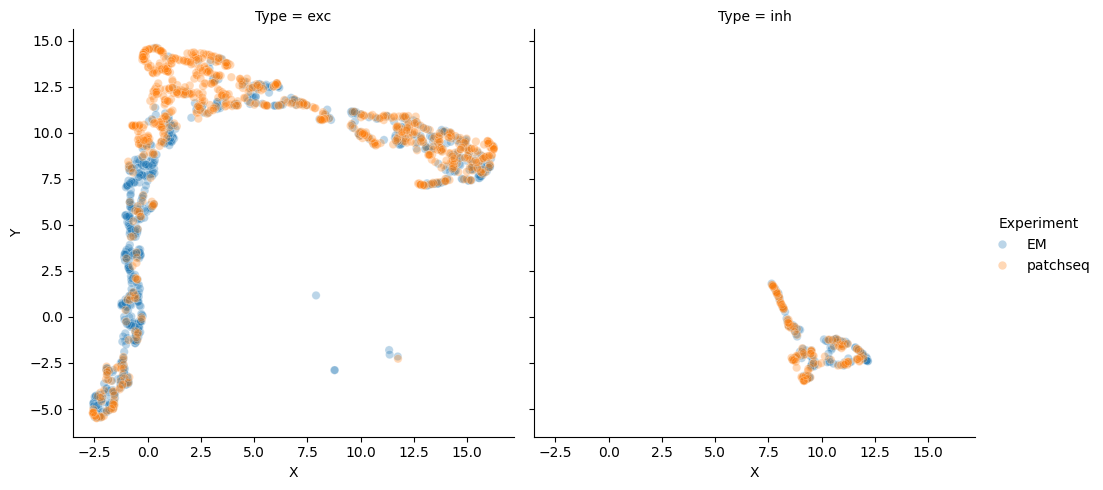

In [125]:
%matplotlib inline
plot = sns.relplot(data = {"X": proj_latent_sep[:, 0], "Y": proj_latent_sep[:, 1], "Experiment": anno_samp["platform"], 
                           "Type": anno_samp["class"]}, x = "X", y = "Y", hue = "Experiment", col = "Type", alpha = 0.3)
plt.show()

Let's now consider what happens to the latent space if we merge the excitatory and inhibitory array slices. We will create an equivalent set of plots to the ones above using a model trained on the merged arbor densities.

In [113]:
combined_dict = np.load("../data/remote/morpho/reference_stopped/outputs.npz")
latent_comb = align(combined_dict["latent_space"], combined_dict["specimen_ids"], anno_full)

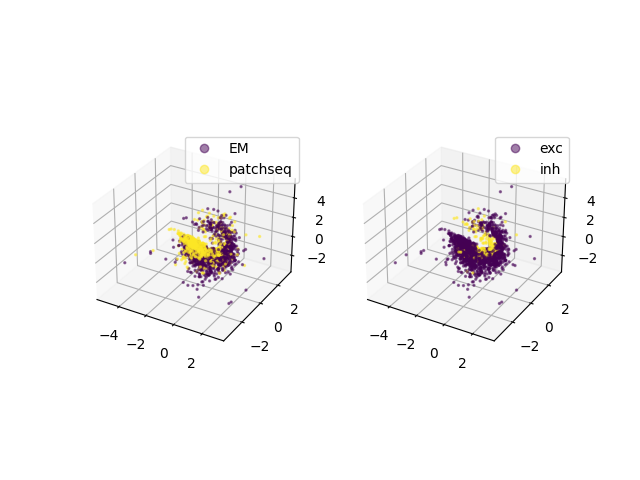

In [144]:
%matplotlib widget
latent_comb_samp = select(latent_comb, anno_samp)
fig_comb = plt.figure()
ax_comb_exp = fig_comb.add_subplot(1, 2, 1, projection = "3d") # For legend to match color with label
ax_comb_type = fig_comb.add_subplot(1, 2, 2, projection = "3d") # For legend to match color with label
(factors_comb_exp, labels_comb_exp) = anno_samp["platform"].factorize()
(factors_comb_type, labels_comb_type) = anno_samp["class"].factorize()
sc_comb_exp = ax_comb_exp.scatter(latent_comb_samp[:, 0], latent_comb_samp[:, 1], latent_comb_samp[:, 2], s = 2, alpha = 0.5, 
                c = factors_comb_exp)
sc_comb_type = ax_comb_type.scatter(latent_comb_samp[:, 0], latent_comb_samp[:, 1], latent_comb_samp[:, 2], s = 2, alpha = 0.5, 
                c = factors_comb_type)
leg_comb_exp = ax_comb_exp.legend(sc_comb_exp.legend_elements()[0], labels_comb_exp.to_list())
leg_comb_type = ax_comb_type.legend(sc_comb_type.legend_elements()[0], labels_comb_type.to_list())
plt.show()

While the latent space is a bit messier in this model, we can easily see from the right plot that excitatory and inhibitory cells are no longer separated, since we've removed the index-based indicator from the input data. From the plot on the left, we once again see a low-dimensional surface that has the same topology as the earlier UMAP projection, now with the inhibitory cells embedded as well.

We can again perform a 2D UMAP projection on the latent space for easier visualization, and see that the horseshoe topology is preserved (with both excitatory and inhibitory cells now placed on the same manifold).

In [115]:
proj_latent_comb = umap.UMAP().fit_transform(latent_comb_samp)

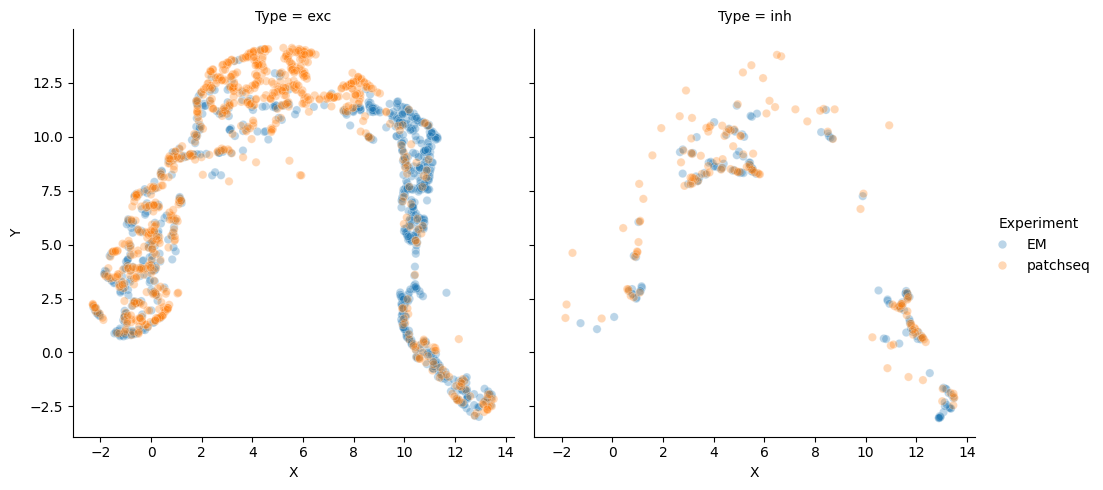

In [129]:
%matplotlib inline
plot = sns.relplot(data = {"X": proj_latent_comb[:, 0], "Y": proj_latent_comb[:, 1], "Experiment": anno_samp["platform"], 
                           "Type": anno_samp["class"]}, x = "X", y = "Y", hue = "Experiment", col = "Type", alpha = 0.3)
plt.show()